In [1]:
#https://www.kaggle.com/code/vmarkin/advatt
# carregar as bibliotecas básicas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# gerar os gráficos logo abaixo dos comandos de plot
%matplotlib inline

In [2]:
train_data_path = '../dataset/X_train_sat6.csv'
train_label_path = '../dataset/y_train_sat6.csv'
test_data_path = '../dataset/X_test_sat6.csv'
test_label_path = '../dataset/y_test_sat6.csv'
train_qtdy = 10
test_qtdy = 5     

In [3]:
def data_read(data_path, nrows):
    data=pd.read_csv(data_path, header=None, nrows=nrows, dtype=np.uint8)
    data=data.values ## converting the data into numpy array
    return data

In [4]:
train_data=data_read(train_data_path, nrows=train_qtdy)
print("Train data shape:" + str(train_data.shape))

##Read training data labels
train_data_label=data_read(train_label_path,nrows=train_qtdy)
print("Train data label shape:" + str(train_data_label.shape))
train_dl = np.zeros((train_qtdy, 8),dtype=np.float32)
train_dl[:, :6] = train_data_label;

##Read test data
test_data=data_read(test_data_path, nrows=test_qtdy)
print("Test data shape:" + str(test_data.shape))


##Read test data labels
test_data_label=data_read(test_label_path,nrows=test_qtdy)
print("Test data label shape:" + str(test_data_label.shape))
test_dl = np.zeros((test_qtdy, 8),dtype=np.float32)
test_dl[:, :6] = test_data_label;

Train data shape:(10, 3136)
Train data label shape:(10, 6)
Test data shape:(5, 3136)
Test data label shape:(5, 6)


In [5]:
example = train_data[0]
print(example.shape)
reshaped_ex = example.reshape((28,28,4))[:,:,:3] #convert to rgb 

ex = np.zeros((32, 32, 3),dtype=np.int32)
ex[:28, :28, :] = reshaped_ex
print(ex)
print(ex.shape)

(3136,)
[[[116 119 118]
  [108 113 118]
  [ 67  60  59]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[122 128 119]
  [113 121 114]
  [ 64  63  46]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[105 105  93]
  [110 117 106]
  [ 95 101  90]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
(32, 32, 3)


In [6]:
from matplotlib import pyplot as plt 

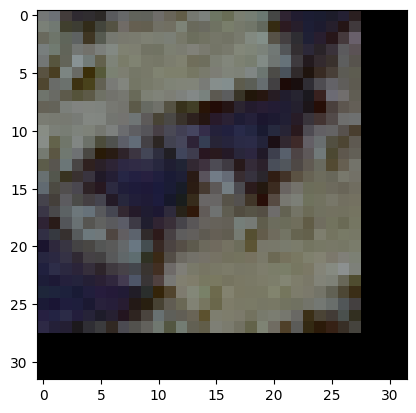

In [7]:
plt.imshow(ex)

In [8]:
ex_label = train_data_label[0]
ex_label

array([0, 0, 1, 0, 0, 0], dtype=uint8)

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from tqdm import tqdm
from sklearn.metrics import accuracy_score

torch.manual_seed(4)

In [10]:
class SatImgDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.transform = T.ToTensor()
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = self.transform(self.X[index])
        y = torch.FloatTensor(self.y[index])
        return {'x':x, 'y':y}

In [11]:
train_data_reshaped = train_data.reshape(train_qtdy,28,28,4)
test_data_reshaped = test_data.reshape(test_qtdy,28,28,4) 

final_train_data = np.zeros((train_qtdy, 32, 32, 4),dtype=np.float32)
final_train_data[:, :28, :28, :] = train_data_reshaped;

final_test_data = np.zeros((test_qtdy, 32, 32, 4),dtype=np.float32)
final_test_data[:, :28, :28, :] = test_data_reshaped;

In [12]:
dataset_train = SatImgDataset(final_train_data, train_dl)
dataset_test = SatImgDataset(final_test_data, test_dl)

loader_train = DataLoader(dataset_train, 512, shuffle=True)
loader_test = DataLoader(dataset_test, 512, shuffle=False)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import brevitas.nn as qnn
from brevitas.quant.scaled_int import Int8ActPerTensorFloat

class QuantizedCNN(nn.Module):
    def __init__(self):
        super(QuantizedCNN, self).__init__()
        # Camada de convolução 1
        self.conv1 = qnn.QuantConv2d(4, 16, kernel_size=3, stride=2, padding=1, weight_bit_width=8, input_quant=Int8ActPerTensorFloat, output_quant=Int8ActPerTensorFloat)
        # Camada de ativação ReLU 1
        self.relu1 = qnn.QuantReLU()
        # Camada de convolução 2
        self.conv2 = qnn.QuantConv2d(16, 8, kernel_size=3, stride=2, padding=1, weight_bit_width=8, input_quant=Int8ActPerTensorFloat, output_quant=Int8ActPerTensorFloat)
        # Camada de ativação ReLU 2
        self.relu2 = qnn.QuantReLU()
        # Camada de convolução 3
        self.conv3 = qnn.QuantConv2d(8, 16, kernel_size=3, stride=2, padding=1, weight_bit_width=8, input_quant=Int8ActPerTensorFloat, output_quant=Int8ActPerTensorFloat)
        # Camada de ativação ReLU 3
        self.relu3 = qnn.QuantReLU()
        # Camada de convolução 4
        self.conv4 = qnn.QuantConv2d(16, 8, kernel_size=3, stride=2, padding=1, weight_bit_width=8, input_quant=Int8ActPerTensorFloat, output_quant=Int8ActPerTensorFloat)
        # Camada de ativação ReLU 4
        self.relu4 = qnn.QuantReLU(return_quant_tensor=True)
        # Camada de pooling global média
        self.global_pool = qnn.TruncAvgPool2d(kernel_size=(2,2), float_to_int_impl_type="FLOOR")

    def forward(self, x):
        # Passo através da primeira convolução e ativação
        x = self.conv1(x)
        x = self.relu1(x)
        # Passo através da segunda convolução e ativação
        x = self.conv2(x)
        x = self.relu2(x)
        # Passo através da terceira convolução e ativação
        x = self.conv3(x)
        x = self.relu3(x)
        # Passo através da quarta convolução e ativação
        x = self.conv4(x)
        x = self.relu4(x)
        # Pooling global médio
        x = self.global_pool(x)
        # x = self.softmax(x)
        # # Achatamento para a saída
        x = x.view(x.size(0), -1)
        return x

In [31]:
model = QuantizedCNN()
device = torch.device('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 30
criterion = nn.CrossEntropyLoss()
model.train()
for e in range(epochs):
    for batch in tqdm(loader_train):
        pred = model(batch['x'].to(device))
        loss = criterion( pred, batch['y'].to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 24.91it/s]


In [32]:
def fast_gradient_sign_method(model, imgs, labels, attack_params):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    pred_logprob = torch.log(preds)
    #print(labels.dtype)
    # Calculate loss by NLL
    loss = nn.CrossEntropyLoss()(preds, labels.to(device))
    loss.backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + attack_params['epsilon'] * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

In [33]:
def eval_model(model, dataloader, fake_generator=None, attack_params=None):
    y_pred = []
    y_true = []
    
    for i, batch in enumerate(dataloader):
        if fake_generator is not None:
            fake_imgs, _ = fake_generator(model, batch['x'],batch['y'], attack_params)
            with torch.no_grad():
                pred = model(fake_imgs.to(device))
        else:
            with torch.no_grad():
                pred = model(batch['x'].to(device))
        y_pred.append(pred.argmax(dim=1).cpu().numpy())
        y_true.append(batch['y'].argmax(dim=1).numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    return accuracy_score(y_true, y_pred)

In [34]:
# eps = np.logspace(-2, 0, 10)
# acc_attack = [eval_model(model, loader_test, fast_gradient_sign_method, {'epsilon': e}) for e in eps]

/tmp/ipykernel_6286/2119712547.py:5: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:350.)
  pred_logprob = torch.log(preds)


AttributeError: 'QuantTensor' object has no attribute 'argmax'

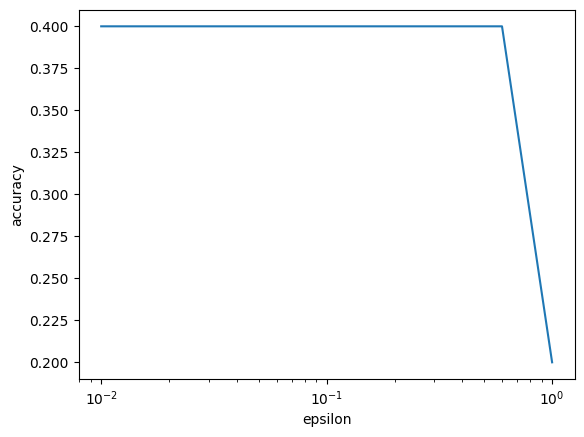

In [35]:
# plt.figure()
# plt.plot(eps, acc_attack)
# plt.xscale('log')
# plt.ylabel("accuracy")
# plt.xlabel('epsilon')
# plt.show()

In [36]:
def predict_one_image(model, img_data, y):
    with torch.no_grad():
        pred = model(T.ToTensor()(img_data).unsqueeze(0).to(device))
    true_label = y.argmax()
    pred_label = pred[0].argmax()
    print(pred)
    plt.imshow(img_data.astype(int))
    print("True class: {}, predicted class: {}".format(true_label, pred_label))

QuantTensor(value=tensor([[1.6339, 1.2987, 0.3771, 0.8169, 0.1676, 0.1047, 0.0000, 0.7751]]), scale=tensor(0.0209), zero_point=tensor(0.), bit_width=tensor(8.), signed_t=tensor(False), training_t=tensor(True))
True class: 2, predicted class: 0


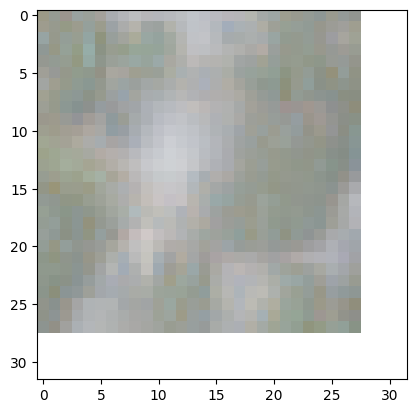

In [37]:
attack_params = {'epsilon':0.02}

image_index = 0

img_data = test_data[image_index].reshape((28,28,4))

ex_img = np.zeros((32, 32, 4),dtype=np.float32)
ex_img[:28, :28, :] = img_data

labels = torch.FloatTensor(test_data_label[image_index]).unsqueeze(0)
predict_one_image(model, ex_img, labels)

In [39]:
with torch.no_grad():
    correct = 0
    i=0
    for batch in loader_test:
        pred = model(batch['x'].to(device))
        predicted = torch.max(pred, 1)[1]
        real_class = torch.max(batch['y'].to(device), 1)[1]
        correct += (predicted == real_class).sum()
        if (i % 100 == 0):
            print(predicted)
            print(real_class)
        i += 1

print(f"certos: {correct.item()}!!!")
print(f"precisão: {correct.item()/len(dataset_test)*100}%!!!")


tensor([0, 1, 0, 0, 0])
tensor([2, 2, 5, 1, 5])
certos: 0!!!
precisão: 0.0%!!!


/tmp/ipykernel_6286/2943965342.py:6: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:350.)
  predicted = torch.max(pred, 1)[1]


In [40]:
#salvar e carregar o modelo de NN
torch.save(model.state_dict(), "cnn-sat6-w8.pt")

QuantTensor(value=tensor([[1.6205, 1.3190, 0.4145, 0.8291, 0.1507, 0.1131, 0.0000, 0.7914]]), scale=tensor(0.0377), zero_point=tensor(0.), bit_width=tensor(8.), signed_t=tensor(False), training_t=tensor(True))
True class: 2, predicted class: 0


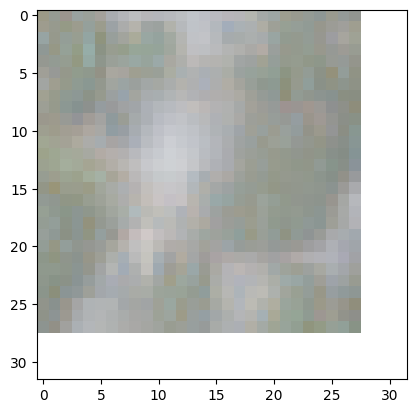

In [41]:
new_model = QuantizedCNN()
new_model.load_state_dict(torch.load("cnn-sat6-w8.pt"))
predict_one_image(new_model, ex_img, labels)